✓ Total de mensagens: 7250
✓ Remetentes: ['Alanis fresca', 'Cassiano']


,data,hora,data_dt,remetente,mensagem
0,20/12/25,10:00:00 PM,2025-12-20 22:00:00,Alanis fresca,QUE ABUSADO
1,20/12/25,10:00:03 PM,2025-12-20 22:00:03,Cassiano,tá ferrada
2,20/12/25,10:00:04 PM,2025-12-20 22:00:04,Alanis fresca,seu
3,20/12/25,10:00:07 PM,2025-12-20 22:00:07,Cassiano,próxima pedra q eu ver
4,20/12/25,10:00:14 PM,2025-12-20 22:00:14,Cassiano,ira pra sua direção


✓ Respostas válidas: 1911


,data,hora,data_dt,remetente,mensagem,remetente_anterior,data_anterior,tempo_resposta_min
1,20/12/25,10:00:03 PM,2025-12-20 22:00:03,Cassiano,tá ferrada,Alanis fresca,2025-12-20 22:00:00,0.050000
2,20/12/25,10:00:04 PM,2025-12-20 22:00:04,Alanis fresca,seu,Cassiano,2025-12-20 22:00:03,0.016667
3,20/12/25,10:00:07 PM,2025-12-20 22:00:07,Cassiano,próxima pedra q eu ver,Alanis fresca,2025-12-20 22:00:04,0.050000
7,20/12/25,10:00:24 PM,2025-12-20 22:00:24,Cassiano,eu n tenho problemas,Alanis fresca,2025-12-20 22:00:21,0.050000
8,20/12/25,10:00:27 PM,2025-12-20 22:00:27,Alanis fresca,se vc é corajoso,Cassiano,2025-12-20 22:00:24,0.050000


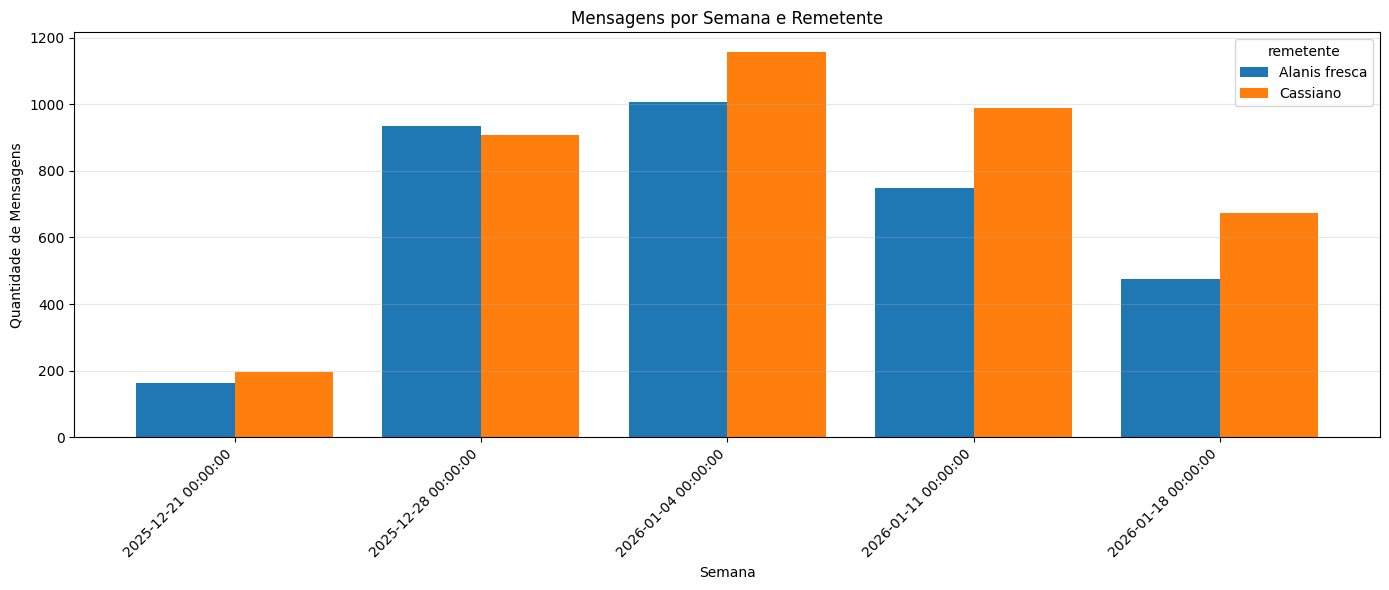

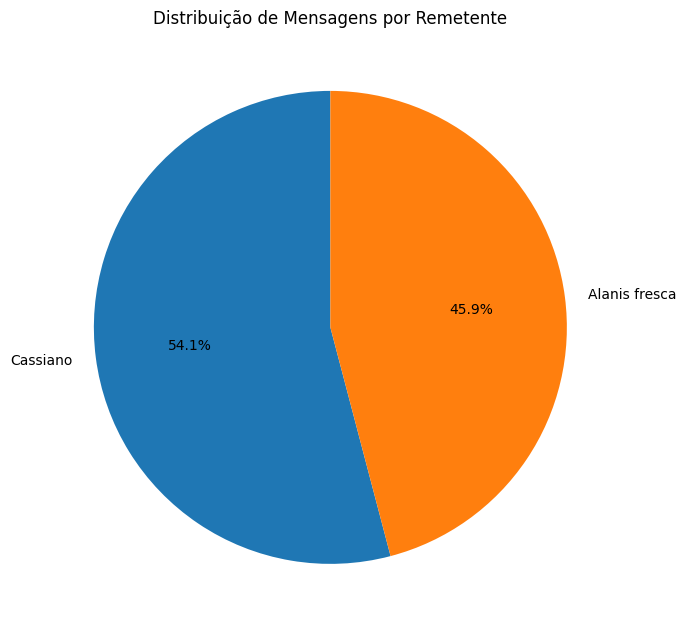

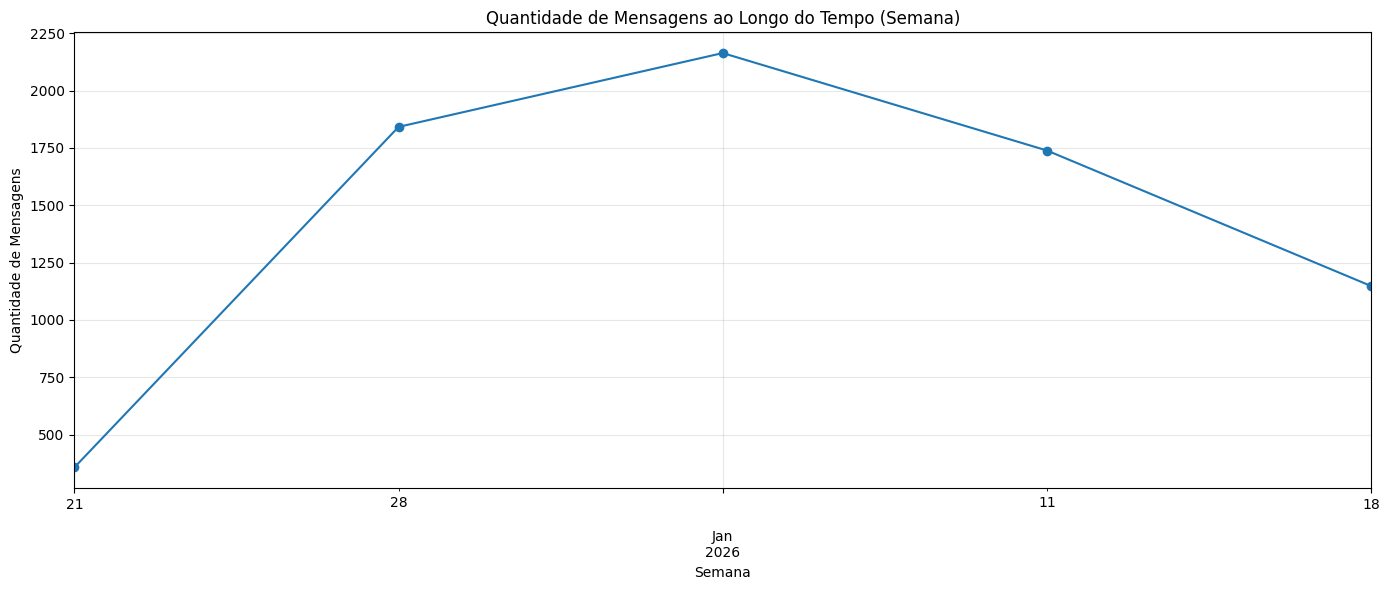

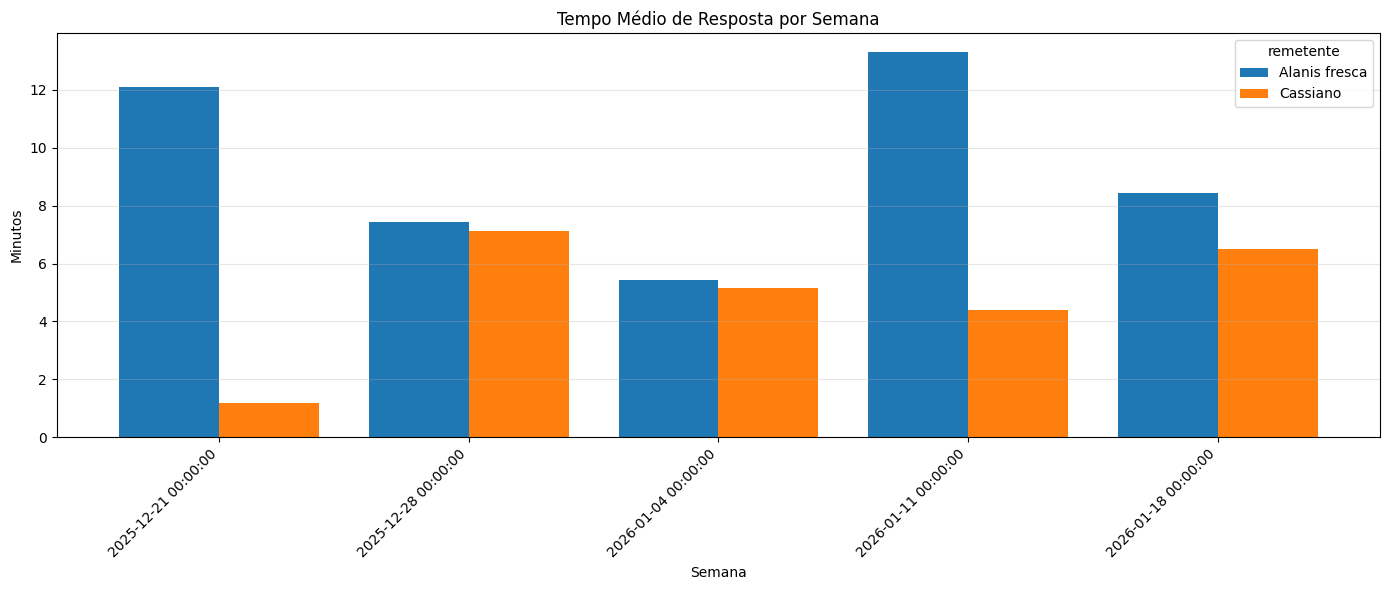

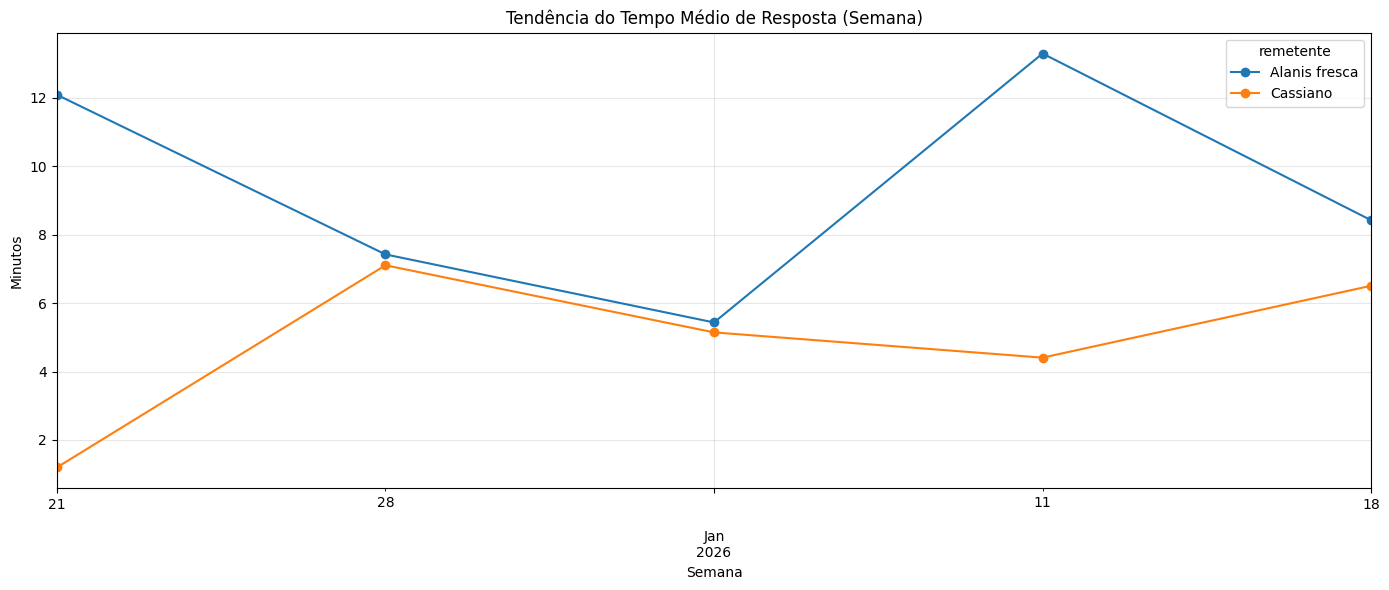

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

arquivo = "_chat.txt"
padrao = r'\[(\d{2}/\d{2}/\d{2}),\s(\d{2}:\d{2}:\d{2}\s(?:AM|PM))\]\s(.+?):\s(.+?)(?=\n\[|$)'

with open(arquivo, 'r', encoding='utf-8') as f:
    conteudo = f.read()

mensagens = re.findall(padrao, conteudo, re.DOTALL)

dados = []
for data, hora, remetente, mensagem in mensagens:
    mensagem = mensagem.strip()

    if 'omitted' in mensagem.lower() or 'encrypted' in mensagem.lower():
        continue

    data_dt = pd.to_datetime(
        f"{data} {hora}",
        format="%d/%m/%y %I:%M:%S %p",
        errors="coerce"
    )

    dados.append({
        'data': data,
        'hora': hora,
        'data_dt': data_dt,
        'remetente': remetente.strip(),
        'mensagem': mensagem
    })

df = (
    pd.DataFrame(dados)
    .dropna(subset=['data_dt'])
    .sort_values('data_dt')
    .reset_index(drop=True)
)

print(f"✓ Total de mensagens: {len(df)}")
print(f"✓ Remetentes: {df['remetente'].unique().tolist()}")
display(df.head())

df_resp = df.copy()

df_resp['remetente_anterior'] = df_resp['remetente'].shift(1)
df_resp['data_anterior'] = df_resp['data_dt'].shift(1)

df_resp['tempo_resposta_min'] = (
    (df_resp['data_dt'] - df_resp['data_anterior'])
    .dt.total_seconds() / 60
)

# Só quando há troca de remetente (resposta real)
df_resp = df_resp[
    df_resp['remetente'] != df_resp['remetente_anterior']
].copy()

# Remove tempos inválidos ou absurdos
df_resp = df_resp[
    (df_resp['tempo_resposta_min'] > 0) &
    (df_resp['tempo_resposta_min'] < 720)  # até 12h
]

print(f"✓ Respostas válidas: {len(df_resp)}")
display(df_resp.head())

PERIODO = 'W'  # 'D' dia | 'W' semana | 'M' mês
PERIODO_NOME = {'D':'Dia', 'W':'Semana', 'M':'Mês'}[PERIODO]

## Mensagens por período e remetente — BARRA
msgs_periodo = (
    df
    .set_index('data_dt')
    .groupby([pd.Grouper(freq=PERIODO), 'remetente'])
    .size()
    .unstack(fill_value=0)
)

msgs_periodo.plot(
    kind='bar',
    figsize=(14,6),
    width=0.8
)

plt.title(f'Mensagens por {PERIODO_NOME} e Remetente')
plt.xlabel(PERIODO_NOME)
plt.ylabel('Quantidade de Mensagens')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##Distribuição de mensagens por remetente — PIZZA

msgs_por_remetente = df['remetente'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    msgs_por_remetente,
    labels=msgs_por_remetente.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribuição de Mensagens por Remetente')
plt.tight_layout()
plt.show()

##Quantidade de mensagens ao longo do tempo — LINHA
msgs_tempo = (
    df
    .set_index('data_dt')
    .groupby(pd.Grouper(freq=PERIODO))
    .size()
)

plt.figure(figsize=(14,6))
msgs_tempo.plot(marker='o')

plt.title(f'Quantidade de Mensagens ao Longo do Tempo ({PERIODO_NOME})')
plt.xlabel(PERIODO_NOME)
plt.ylabel('Quantidade de Mensagens')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##Tempo médio de resposta por período — BARRA
tempo_medio = (
    df_resp
    .set_index('data_dt')
    .groupby([pd.Grouper(freq=PERIODO), 'remetente'])['tempo_resposta_min']
    .mean()
    .unstack()
)

tempo_medio.plot(
    kind='bar',
    figsize=(14,6),
    width=0.8
)

plt.title(f'Tempo Médio de Resposta por {PERIODO_NOME}')
plt.xlabel(PERIODO_NOME)
plt.ylabel('Minutos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##Tempo médio de resposta — LINHA (TENDÊNCIA)
tempo_medio.plot(
    kind='line',
    marker='o',
    figsize=(14,6)
)

plt.title(f'Tendência do Tempo Médio de Resposta ({PERIODO_NOME})')
plt.xlabel(PERIODO_NOME)
plt.ylabel('Minutos')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()